In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [3]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


In [4]:
def indices_array(n):
    r = np.arange(n)
    out = np.empty((n,n,2),dtype=int)
    out[:,:,0] = r[:,None]
    out[:,:,1] = r
    return out

In [5]:
def getFashionMNIST(batch_size = 320):
    fashionmnist_data = torchvision.datasets.FashionMNIST(download=True, root = 'data/fashionmnist', transform = 
                                                                                 transforms.Compose([transforms.Resize(32),
                                                                                 transforms.ToTensor(), 
                                                                                 transforms.Lambda(lambda x: x.repeat(1, 1, 1))
                                                                                 ]))
    train_loader = torch.utils.data.DataLoader(fashionmnist_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=16)
    return train_loader, train_loader



def getDataset(dataset = "MNIST", batch_size = 320):
    if(dataset == "MNIST"):
        train_loader, test_loader = getMNIST(batch_size)
        noChannels,dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "FashionMNIST"):
        train_loader, test_loader = getFashionMNIST(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "Cifar10"):
        train_loader, test_loader = getCifar10(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    elif(dataset == "cityscapes"):
        train_loader, test_loader = getcityscapes(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    else:
        return None, None, None, None, None    
        
    return train_loader, test_loader, noChannels, dx, dy

In [6]:
def ImageDistancesFromBarycenter(batch_x, input_barycenter, remaining_indices):
  wasserDistance = []
  distance_cum_index = np.array([])
  #Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
  #for j in range(batch_x.shape[0]):
  for j in remaining_indices:
    gs = ((batch_x[j][0] + 10**(-10)).reshape(1024,1)) / torch.sum((batch_x[j][0]))
    h = ((input_barycenter + 10**(-10)).reshape(1024,1)) / torch.sum((input_barycenter))
    wassDistance = ot.sinkhorn2(h, gs, Mm, 1)
    
    distance_cum_index = np.concatenate((distance_cum_index, ([wassDistance[0],j])), axis = 0)

  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  #distance_cum_index gives wasserstein distances of all images from the input barycenter
  distance_cum_index = np.array(distance_cum_index)
  remaining_indices = distance_cum_index[:,1][4:]
  remaining_indices = remaining_indices.astype(int)
    


  f1 = batch_x[int(distance_cum_index[:,1][0])][0].cpu().detach().numpy()
  f2 = batch_x[int(distance_cum_index[:,1][1])][0].cpu().detach().numpy()
  f3 = batch_x[int(distance_cum_index[:,1][2])][0].cpu().detach().numpy()
  f4 = batch_x[int(distance_cum_index[:,1][3])][0].cpu().detach().numpy()  

  A = np.array([f1, f2, f3, f4])
  reg = 0.004
  weights = np.array((0.25, 0.25, 0.25, 0.25))
  next_barycenter = ot.bregman.convolutional_barycenter2d(A, reg, weights) 
  next_barycenter = torch.tensor(next_barycenter)
  next_barycenter = next_barycenter.type(torch.FloatTensor)
      
  return A, next_barycenter, remaining_indices

In [7]:
train_loader, test_loader, noChannels, dx, dy = getDataset("FashionMNIST")  # FashionMNIST , MNIST

/home/chethan/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
for inum, (batch_x, label) in enumerate(train_loader):
    break
    

In [9]:
imageIndices = indices_array(batch_x.shape[3]).reshape(32*32,2)


In [10]:
Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]

In [11]:
Mm = torch.tensor(Mm).type(torch.FloatTensor)

In [12]:
# Wasserstein cluster jump

Size of batch :  320
Iteration number :  1
Input barycenter : 


/tmp/ipykernel_28829/3832836997.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


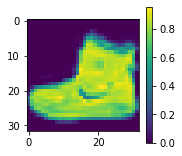

/tmp/ipykernel_28829/3832836997.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbours, bary, rem_indices = ImageDistancesFromBarycenter(batch_x, torch.tensor(bary), rem_indices)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 5
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 6
  warnings.warn('Warning: num

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 26
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 116
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 79
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 22
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 236
  warnings.warn('Warning: numerical errors a

Neighbors of input barycenter :



/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:2088: UserWarning: Convolutional Sinkhorn did not converge. Try a larger number of iterations `numItermax` or a larger entropy `reg`.
  warnings.warn("Convolutional Sinkhorn did not converge. "


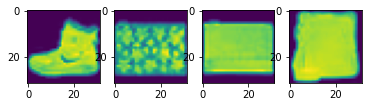

/tmp/ipykernel_28829/3832836997.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


The new barycenter


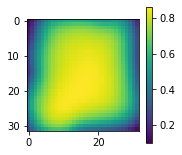

Tracking distance between new barycenter and previous barycenter :  tensor([5.1741])
torch.Size([32, 32])
Iteration number :  2
Input barycenter : 


/tmp/ipykernel_28829/3832836997.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gs = ((torch.tensor(old_bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(old_bary)))
/tmp/ipykernel_28829/3832836997.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = ((torch.tensor(bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(bary)))
/tmp/ipykernel_28829/3832836997.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)


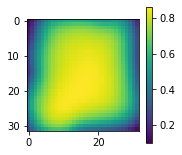

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 497
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 30
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 108
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 12
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 73
  warnings.warn('Warning: numerical errors a

Neighbors of input barycenter :



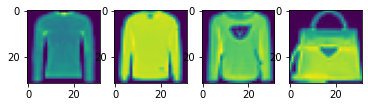

The new barycenter


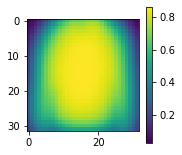

Tracking distance between new barycenter and previous barycenter :  tensor([1.4209])
Iteration number :  3
Input barycenter : 


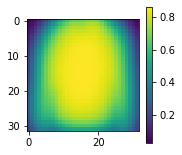

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 50
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 208
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 31
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 71
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 94
  warnings.warn('Warning: numerical errors at

Neighbors of input barycenter :



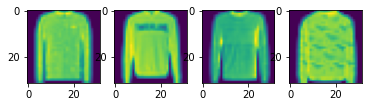

The new barycenter


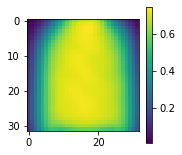

Tracking distance between new barycenter and previous barycenter :  tensor([1.5089])
Iteration number :  4
Input barycenter : 


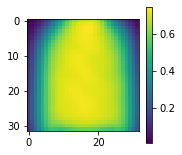

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 477
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 175
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 184
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 81
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 117
  warnings.warn('Warning: numerical errors

Neighbors of input barycenter :



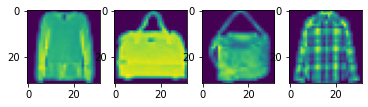

The new barycenter


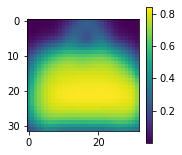

Tracking distance between new barycenter and previous barycenter :  tensor([5.3347])
torch.Size([64, 32])
Iteration number :  5
Input barycenter : 


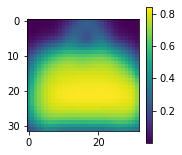

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 139
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 161
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 104
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 119
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 191
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



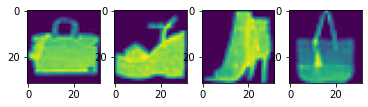

The new barycenter


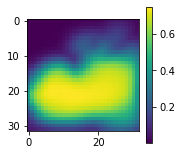

Tracking distance between new barycenter and previous barycenter :  tensor([1.6421])
Iteration number :  6
Input barycenter : 


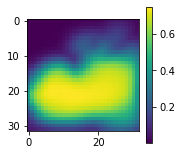

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 44
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 130
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 46
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



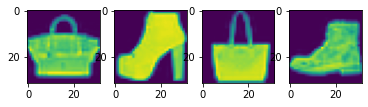

The new barycenter


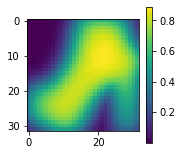

Tracking distance between new barycenter and previous barycenter :  tensor([6.8700])
torch.Size([96, 32])
Iteration number :  7
Input barycenter : 


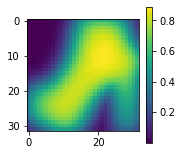

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 58
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 74
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 190
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



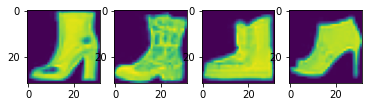

The new barycenter


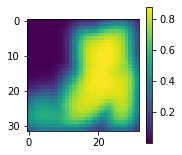

Tracking distance between new barycenter and previous barycenter :  tensor([3.2687])
Iteration number :  8
Input barycenter : 


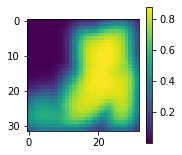

Neighbors of input barycenter :



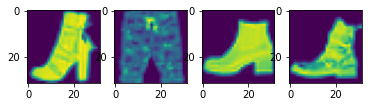

The new barycenter


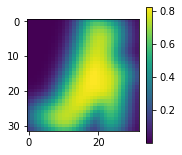

Tracking distance between new barycenter and previous barycenter :  tensor([4.2426])
torch.Size([128, 32])
Iteration number :  9
Input barycenter : 


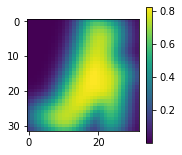

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 56
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 126
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 137
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



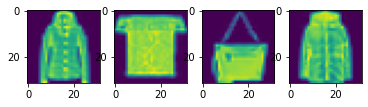

The new barycenter


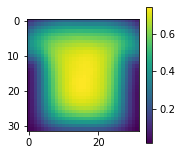

Tracking distance between new barycenter and previous barycenter :  tensor([3.2310])
Iteration number :  10
Input barycenter : 


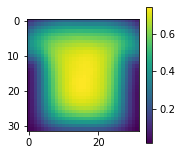

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 206
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 178
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 326
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 350
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 228
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



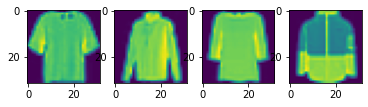

The new barycenter


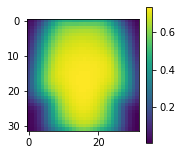

Tracking distance between new barycenter and previous barycenter :  tensor([1.9606])
Iteration number :  11
Input barycenter : 


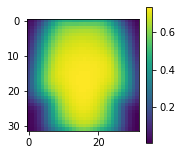

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 150
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 463
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 210
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 194
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 341
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



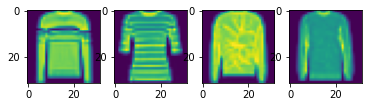

The new barycenter


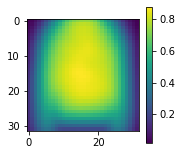

Tracking distance between new barycenter and previous barycenter :  tensor([1.6745])
Iteration number :  12
Input barycenter : 


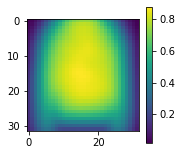

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 141
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 676
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 257
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 717
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 166
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



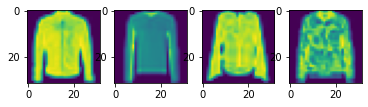

The new barycenter


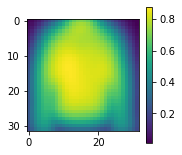

Tracking distance between new barycenter and previous barycenter :  tensor([1.6914])
Iteration number :  13
Input barycenter : 


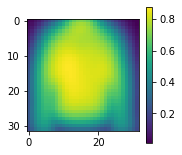

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 140
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 138
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 230
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 197
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 115
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



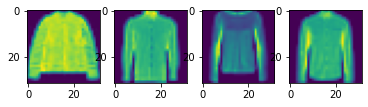

The new barycenter


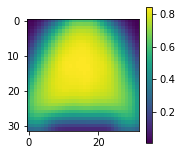

Tracking distance between new barycenter and previous barycenter :  tensor([1.6929])
Iteration number :  14
Input barycenter : 


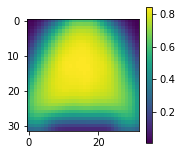

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 276
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 274
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 246
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 249
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 172
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



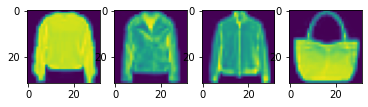

The new barycenter


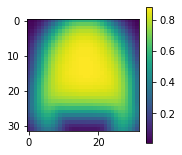

Tracking distance between new barycenter and previous barycenter :  tensor([1.8130])
Iteration number :  15
Input barycenter : 


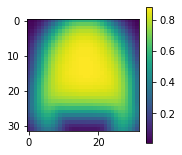

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 374
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 211
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 151
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 282
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 387
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



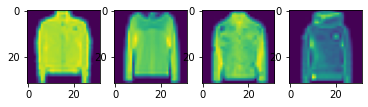

The new barycenter


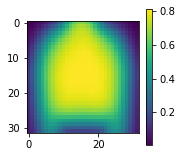

Tracking distance between new barycenter and previous barycenter :  tensor([2.0967])
Iteration number :  16
Input barycenter : 


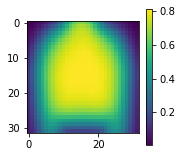

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 279
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 373
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 155
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 302
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 156
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



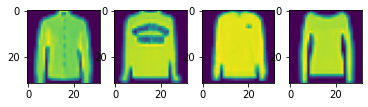

The new barycenter


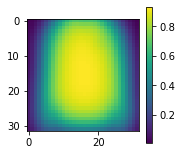

Tracking distance between new barycenter and previous barycenter :  tensor([1.5005])
Iteration number :  17
Input barycenter : 


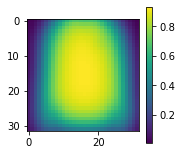

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 342
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 720
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 244
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 417
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 505
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



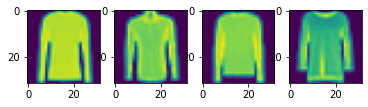

The new barycenter


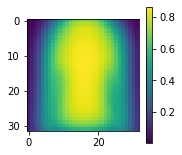

Tracking distance between new barycenter and previous barycenter :  tensor([1.2030])
Iteration number :  18
Input barycenter : 


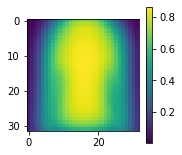

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 385
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 270
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 185
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 767
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 309
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



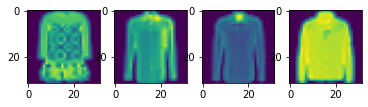

The new barycenter


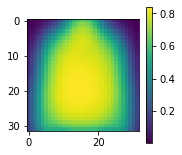

Tracking distance between new barycenter and previous barycenter :  tensor([3.2266])
Iteration number :  19
Input barycenter : 


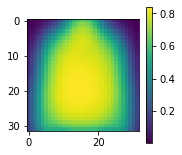

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 390
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 809
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 337
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 180
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 238
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



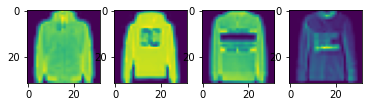

The new barycenter


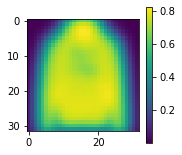

Tracking distance between new barycenter and previous barycenter :  tensor([1.1576])
Iteration number :  20
Input barycenter : 


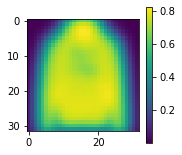

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 461
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 67
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 679
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



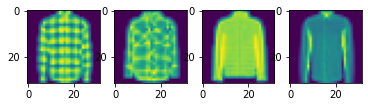

The new barycenter


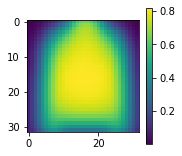

Tracking distance between new barycenter and previous barycenter :  tensor([1.7079])
Iteration number :  21
Input barycenter : 


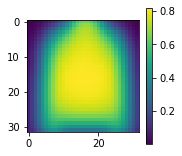

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 135
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



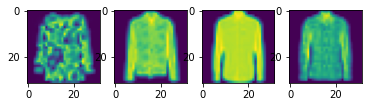

The new barycenter


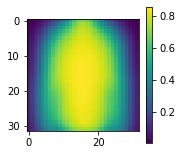

Tracking distance between new barycenter and previous barycenter :  tensor([1.5377])
Iteration number :  22
Input barycenter : 


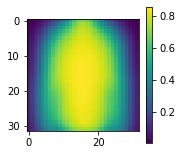

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 247
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 344
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 754
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 444
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



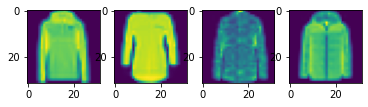

The new barycenter


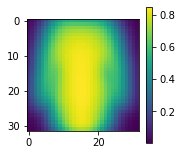

Tracking distance between new barycenter and previous barycenter :  tensor([2.3517])
Iteration number :  23
Input barycenter : 


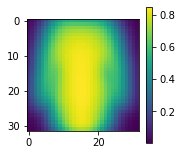

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 293
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 136
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 708
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 232
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 320
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



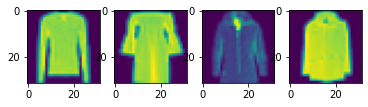

The new barycenter


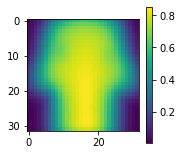

Tracking distance between new barycenter and previous barycenter :  tensor([1.7119])
Iteration number :  24
Input barycenter : 


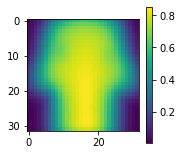

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 173
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 393
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 436
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 345
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 338
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



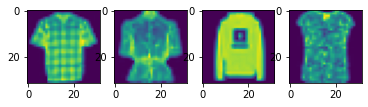

The new barycenter


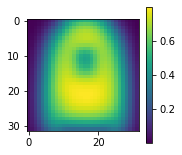

Tracking distance between new barycenter and previous barycenter :  tensor([2.9317])
Iteration number :  25
Input barycenter : 


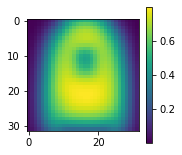

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 361
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



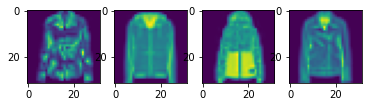

The new barycenter


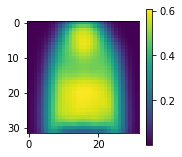

Tracking distance between new barycenter and previous barycenter :  tensor([2.6030])
Iteration number :  26
Input barycenter : 


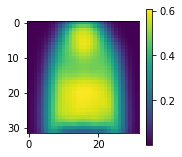

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 380
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 215
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 143
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



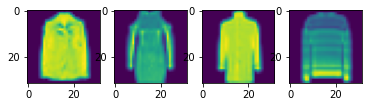

The new barycenter


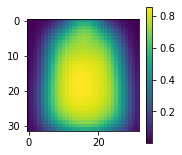

Tracking distance between new barycenter and previous barycenter :  tensor([1.6870])
Iteration number :  27
Input barycenter : 


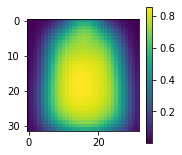

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 165
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



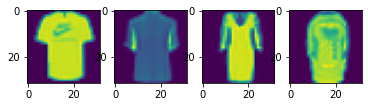

The new barycenter


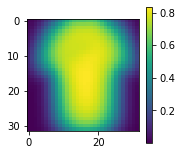

Tracking distance between new barycenter and previous barycenter :  tensor([4.8385])
torch.Size([160, 32])
Iteration number :  28
Input barycenter : 


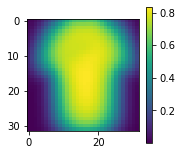

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 217
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 241
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



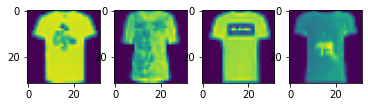

The new barycenter


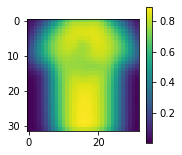

Tracking distance between new barycenter and previous barycenter :  tensor([1.7052])
Iteration number :  29
Input barycenter : 


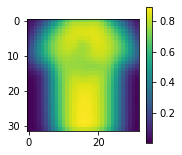

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 766
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 306
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 392
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 310
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



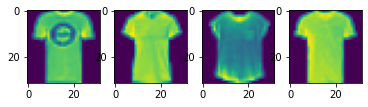

The new barycenter


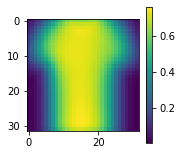

Tracking distance between new barycenter and previous barycenter :  tensor([1.7629])
Iteration number :  30
Input barycenter : 


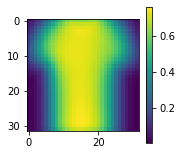

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 423
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 365
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 447
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 192
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



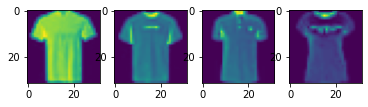

The new barycenter


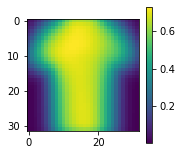

Tracking distance between new barycenter and previous barycenter :  tensor([1.2695])
Iteration number :  31
Input barycenter : 


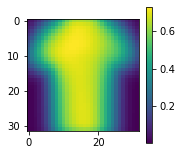

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 199
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



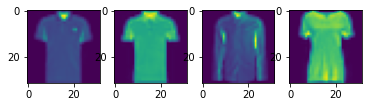

The new barycenter


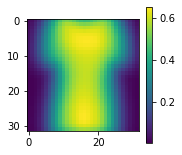

Tracking distance between new barycenter and previous barycenter :  tensor([2.6162])
Iteration number :  32
Input barycenter : 


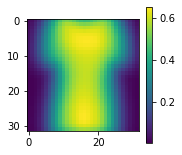

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 226
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 603
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 233
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



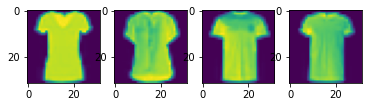

The new barycenter


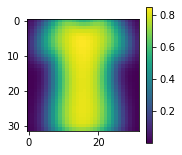

Tracking distance between new barycenter and previous barycenter :  tensor([1.2176])
Iteration number :  33
Input barycenter : 


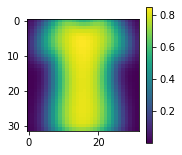

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 162
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 304
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 200
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 399
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



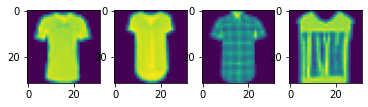

The new barycenter


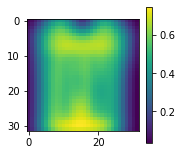

Tracking distance between new barycenter and previous barycenter :  tensor([4.0587])
torch.Size([192, 32])
Iteration number :  34
Input barycenter : 


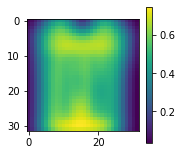

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 231
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 479
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



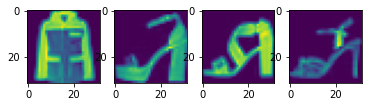

The new barycenter


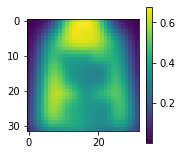

Tracking distance between new barycenter and previous barycenter :  tensor([2.9310])
Iteration number :  35
Input barycenter : 


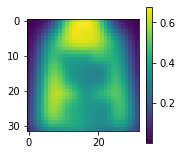

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 265
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



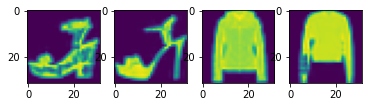

The new barycenter


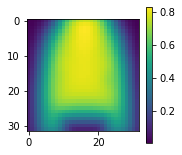

Tracking distance between new barycenter and previous barycenter :  tensor([2.9314])
Iteration number :  36
Input barycenter : 


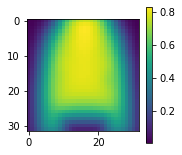

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 332
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 623
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 465
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 223
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



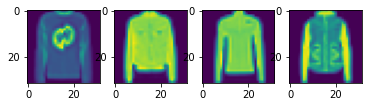

The new barycenter


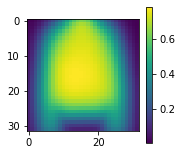

Tracking distance between new barycenter and previous barycenter :  tensor([1.4124])
Iteration number :  37
Input barycenter : 


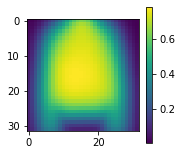

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 377
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 474
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



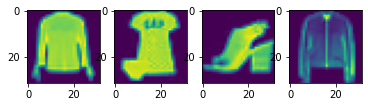

The new barycenter


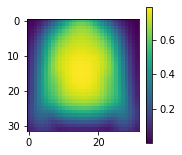

Tracking distance between new barycenter and previous barycenter :  tensor([1.3493])
Iteration number :  38
Input barycenter : 


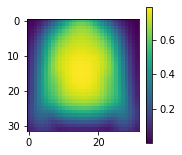

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 297
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



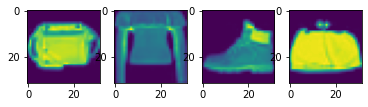

The new barycenter


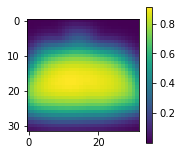

Tracking distance between new barycenter and previous barycenter :  tensor([5.7033])
torch.Size([224, 32])
Iteration number :  39
Input barycenter : 


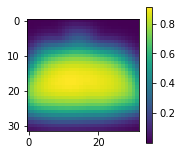

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 312
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 381
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 107
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



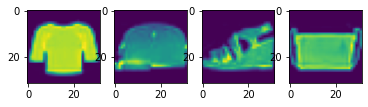

The new barycenter


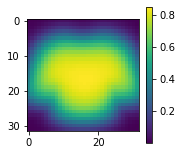

Tracking distance between new barycenter and previous barycenter :  tensor([5.1057])
torch.Size([256, 32])
Iteration number :  40
Input barycenter : 


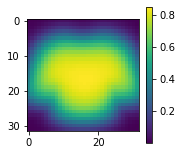

Neighbors of input barycenter :



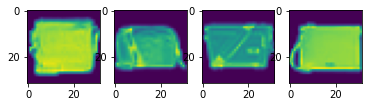

The new barycenter


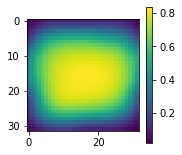

Tracking distance between new barycenter and previous barycenter :  tensor([1.8631])
Iteration number :  41
Input barycenter : 


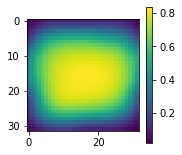

Neighbors of input barycenter :



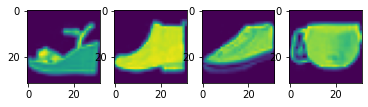

The new barycenter


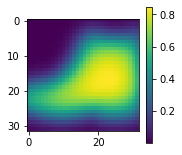

Tracking distance between new barycenter and previous barycenter :  tensor([1.3070])
Iteration number :  42
Input barycenter : 


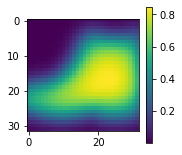

Neighbors of input barycenter :



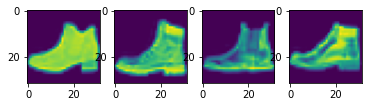

The new barycenter


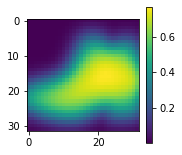

Tracking distance between new barycenter and previous barycenter :  tensor([1.5665])
Iteration number :  43
Input barycenter : 


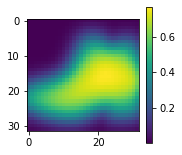

Neighbors of input barycenter :



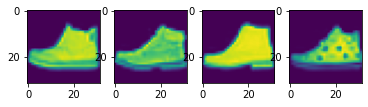

The new barycenter


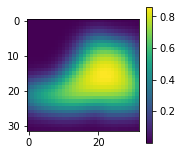

Tracking distance between new barycenter and previous barycenter :  tensor([2.2170])
Iteration number :  44
Input barycenter : 


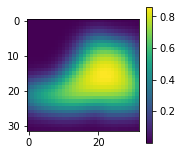

Neighbors of input barycenter :



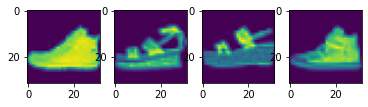

The new barycenter


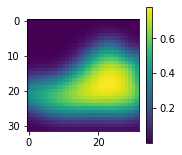

Tracking distance between new barycenter and previous barycenter :  tensor([3.1772])
Iteration number :  45
Input barycenter : 


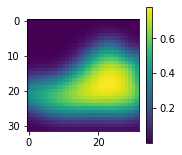

Neighbors of input barycenter :



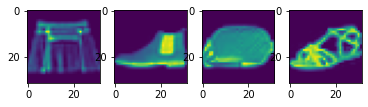

The new barycenter


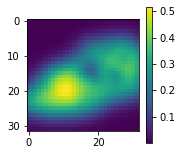

Tracking distance between new barycenter and previous barycenter :  tensor([4.0496])
torch.Size([288, 32])
Iteration number :  46
Input barycenter : 


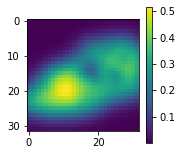

Neighbors of input barycenter :



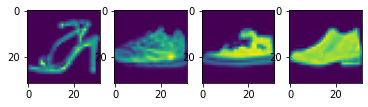

The new barycenter


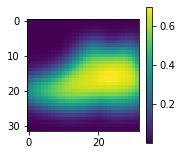

Tracking distance between new barycenter and previous barycenter :  tensor([5.3144])
torch.Size([320, 32])
Iteration number :  47
Input barycenter : 


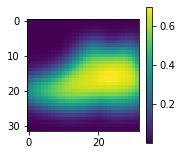

Neighbors of input barycenter :



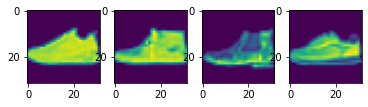

The new barycenter


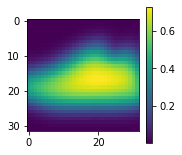

Tracking distance between new barycenter and previous barycenter :  tensor([2.3901])
Iteration number :  48
Input barycenter : 


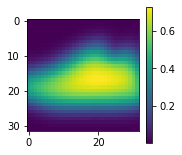

Neighbors of input barycenter :



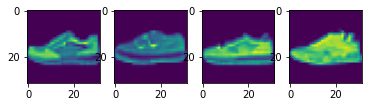

The new barycenter


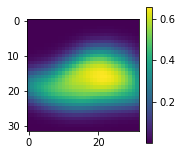

Tracking distance between new barycenter and previous barycenter :  tensor([1.2106])
Iteration number :  49
Input barycenter : 


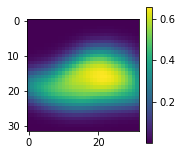

Neighbors of input barycenter :



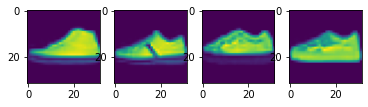

The new barycenter


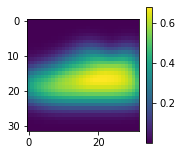

Tracking distance between new barycenter and previous barycenter :  tensor([1.4657])
Iteration number :  50
Input barycenter : 


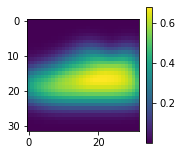

Neighbors of input barycenter :



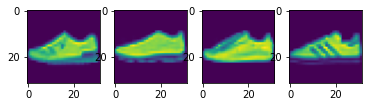

The new barycenter


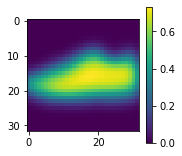

Tracking distance between new barycenter and previous barycenter :  tensor([2.2407])
Iteration number :  51
Input barycenter : 


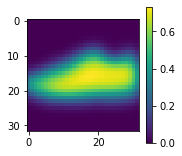

Neighbors of input barycenter :



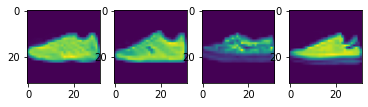

The new barycenter


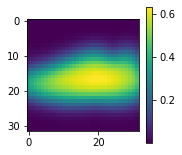

Tracking distance between new barycenter and previous barycenter :  tensor([1.8928])
Iteration number :  52
Input barycenter : 


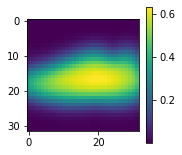

Neighbors of input barycenter :



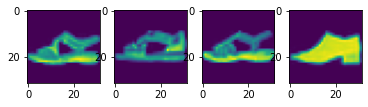

The new barycenter


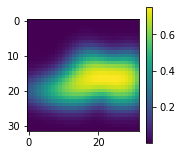

Tracking distance between new barycenter and previous barycenter :  tensor([2.1049])
Iteration number :  53
Input barycenter : 


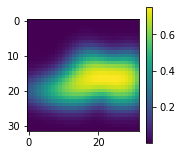

Neighbors of input barycenter :



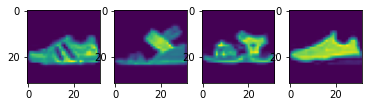

The new barycenter


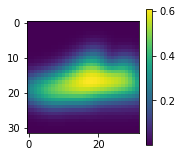

Tracking distance between new barycenter and previous barycenter :  tensor([4.9319])
torch.Size([352, 32])
Iteration number :  54
Input barycenter : 


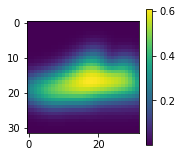

Neighbors of input barycenter :



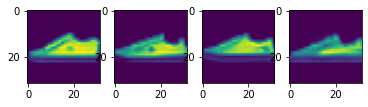

The new barycenter


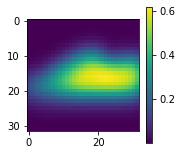

Tracking distance between new barycenter and previous barycenter :  tensor([4.1076])
torch.Size([384, 32])
Iteration number :  55
Input barycenter : 


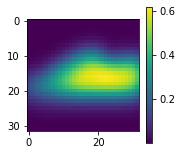

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 305
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



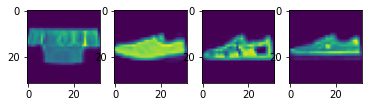

The new barycenter


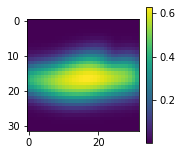

Tracking distance between new barycenter and previous barycenter :  tensor([5.4389])
torch.Size([416, 32])
Iteration number :  56
Input barycenter : 


/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 259
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


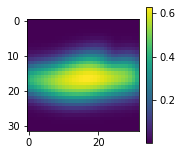

Neighbors of input barycenter :



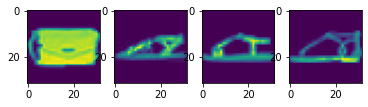

The new barycenter


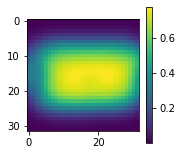

Tracking distance between new barycenter and previous barycenter :  tensor([5.1875])
torch.Size([448, 32])
Iteration number :  57
Input barycenter : 


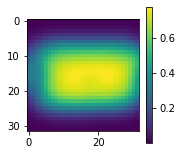

Neighbors of input barycenter :



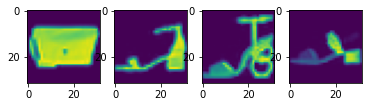

The new barycenter


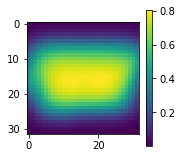

Tracking distance between new barycenter and previous barycenter :  tensor([2.0994])
Iteration number :  58
Input barycenter : 


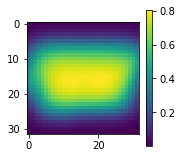

Neighbors of input barycenter :



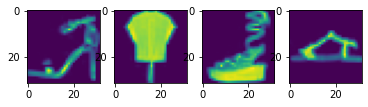

The new barycenter


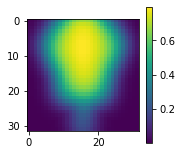

Tracking distance between new barycenter and previous barycenter :  tensor([8.5641])
torch.Size([480, 32])
Iteration number :  59
Input barycenter : 


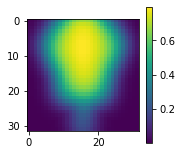

Neighbors of input barycenter :



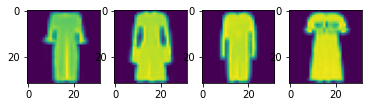

The new barycenter


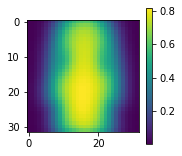

Tracking distance between new barycenter and previous barycenter :  tensor([3.9130])
Iteration number :  60
Input barycenter : 


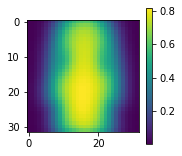

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 209
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 410
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 330
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



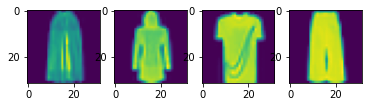

The new barycenter


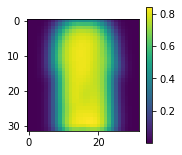

Tracking distance between new barycenter and previous barycenter :  tensor([1.6441])
Iteration number :  61
Input barycenter : 


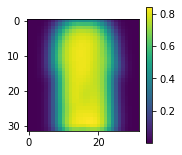

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 315
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 402
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 286
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



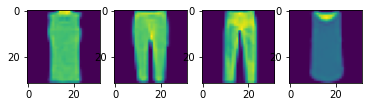

The new barycenter


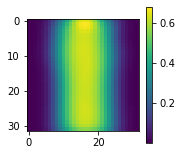

Tracking distance between new barycenter and previous barycenter :  tensor([1.5674])
Iteration number :  62
Input barycenter : 


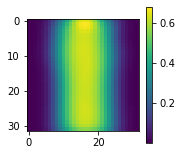

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 494
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 865
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



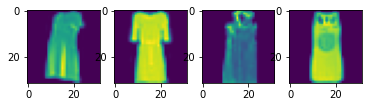

The new barycenter


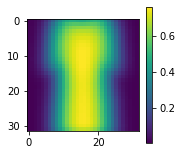

Tracking distance between new barycenter and previous barycenter :  tensor([1.4947])
Iteration number :  63
Input barycenter : 


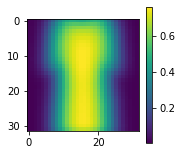

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 466
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



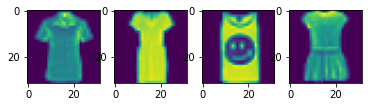

The new barycenter


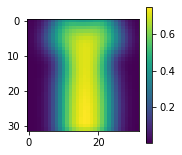

Tracking distance between new barycenter and previous barycenter :  tensor([1.5644])
Iteration number :  64
Input barycenter : 


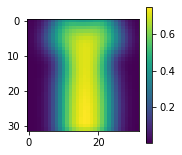

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 870
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 543
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 718
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



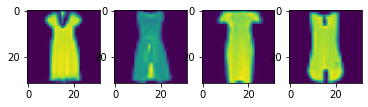

The new barycenter


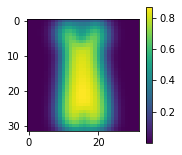

Tracking distance between new barycenter and previous barycenter :  tensor([2.8405])
Iteration number :  65
Input barycenter : 


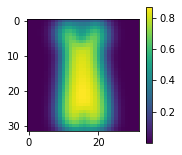

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 253
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



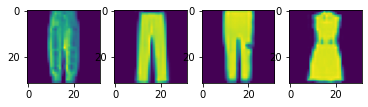

The new barycenter


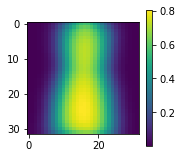

Tracking distance between new barycenter and previous barycenter :  tensor([2.0171])
Iteration number :  66
Input barycenter : 


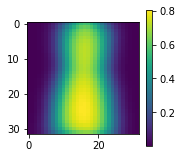

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 195
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 237
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



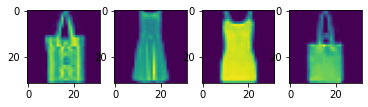

The new barycenter


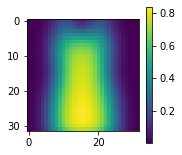

Tracking distance between new barycenter and previous barycenter :  tensor([3.1724])
Iteration number :  67
Input barycenter : 


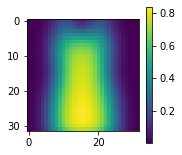

Neighbors of input barycenter :



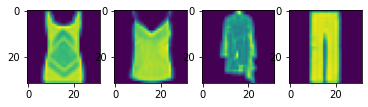

The new barycenter


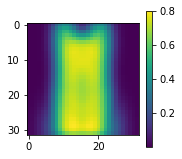

Tracking distance between new barycenter and previous barycenter :  tensor([3.3912])
Iteration number :  68
Input barycenter : 


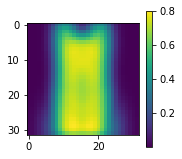

Neighbors of input barycenter :



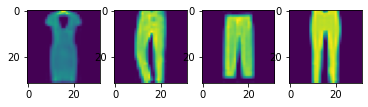

The new barycenter


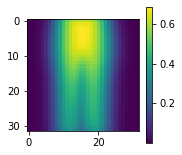

Tracking distance between new barycenter and previous barycenter :  tensor([5.2527])
torch.Size([512, 32])
Iteration number :  69
Input barycenter : 


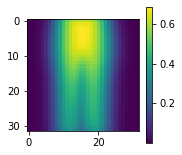

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 252
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



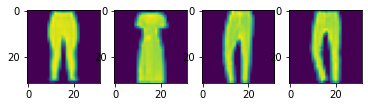

The new barycenter


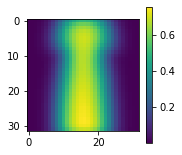

Tracking distance between new barycenter and previous barycenter :  tensor([8.4658])
torch.Size([544, 32])
Iteration number :  70
Input barycenter : 


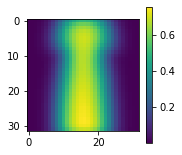

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 510
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



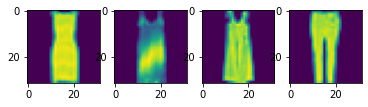

The new barycenter


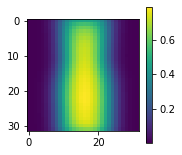

Tracking distance between new barycenter and previous barycenter :  tensor([1.4305])
Iteration number :  71
Input barycenter : 


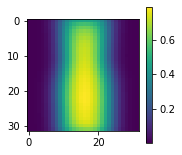

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 313
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



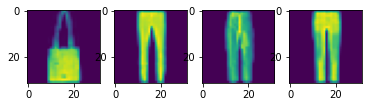

The new barycenter


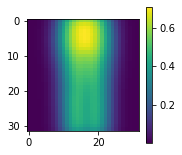

Tracking distance between new barycenter and previous barycenter :  tensor([7.2812])
torch.Size([576, 32])
Iteration number :  72
Input barycenter : 


/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 438
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


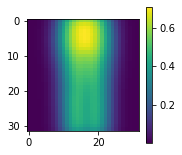

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 187
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



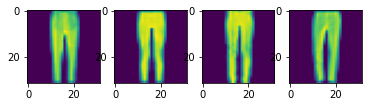

The new barycenter


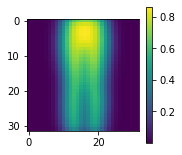

Tracking distance between new barycenter and previous barycenter :  tensor([1.6867])
Iteration number :  73
Input barycenter : 


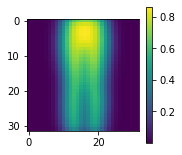

Neighbors of input barycenter :



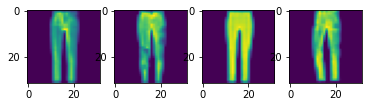

The new barycenter


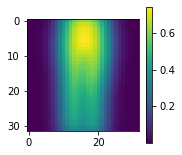

Tracking distance between new barycenter and previous barycenter :  tensor([1.4304])
Iteration number :  74
Input barycenter : 


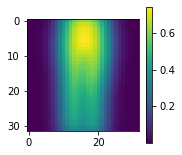

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 152
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



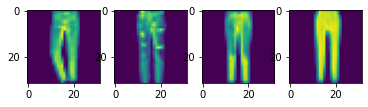

The new barycenter


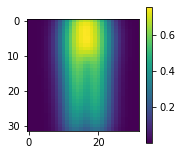

Tracking distance between new barycenter and previous barycenter :  tensor([1.5107])
Iteration number :  75
Input barycenter : 


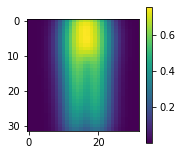

Neighbors of input barycenter :



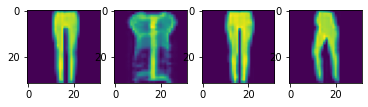

The new barycenter


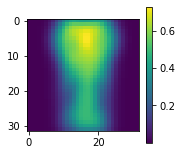

Tracking distance between new barycenter and previous barycenter :  tensor([1.6637])
Iteration number :  76
Input barycenter : 


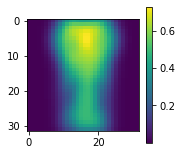

Neighbors of input barycenter :



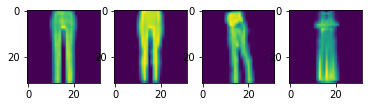

The new barycenter


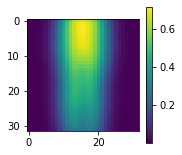

Tracking distance between new barycenter and previous barycenter :  tensor([2.1794])
Iteration number :  77
Input barycenter : 


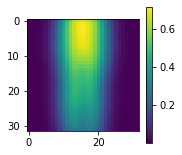

Neighbors of input barycenter :



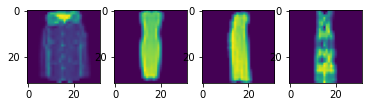

The new barycenter


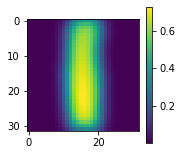

Tracking distance between new barycenter and previous barycenter :  tensor([3.2056])
Iteration number :  78
Input barycenter : 


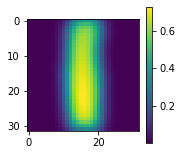

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 335
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



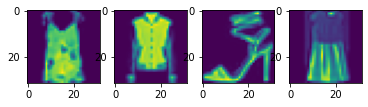

The new barycenter


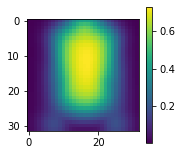

Tracking distance between new barycenter and previous barycenter :  tensor([7.0595])
torch.Size([608, 32])
Iteration number :  79
Input barycenter : 


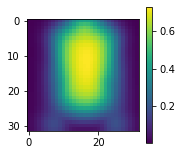

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 261
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



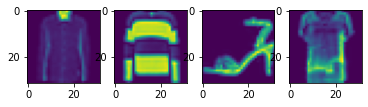

The new barycenter


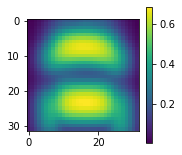

Tracking distance between new barycenter and previous barycenter :  tensor([7.9212])
torch.Size([640, 32])
Iteration number :  80
Input barycenter : 


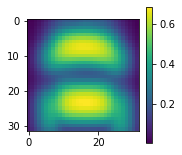

Neighbors of input barycenter :



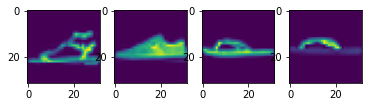

The new barycenter


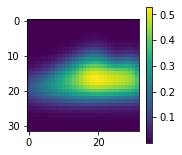

Tracking distance between new barycenter and previous barycenter :  tensor([4.2709])
torch.Size([672, 32])


In [13]:
bary = batch_x[0][0]
rem_indices = np.array(range(0,batch_x.shape[0]))
#Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
print("Size of batch : ", batch_x.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
for i in range(int(batch_x.shape[0]/4)):
    
    if(len(rem_indices) < 4):
        print("END")
        break
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    
    old_bary = bary

    neighbours, bary, rem_indices = ImageDistancesFromBarycenter(batch_x, torch.tensor(bary), rem_indices)
    

    print("Neighbors of input barycenter :")
    print()
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(torch.tensor(neighbours[0]).view(32,32))
    axarr[1].imshow(torch.tensor(neighbours[1]).view(32,32))
    axarr[2].imshow(torch.tensor(neighbours[2]).view(32,32))
    axarr[3].imshow(torch.tensor(neighbours[3]).view(32,32))
    plt.show()

    print("The new barycenter")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    
    gs = ((torch.tensor(old_bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(old_bary)))
    h = ((torch.tensor(bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(bary)))
    wassDistance = ot.sinkhorn2(h, gs, Mm, 1)
    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance >= 4.0):
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)
        print(sampled_barycenters.shape)
sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]*sampled_barycenters.shape[1])/1024), 32, 32)


In [14]:
sampled_barycenters.shape

torch.Size([21, 32, 32])

/tmp/ipykernel_28829/2811262560.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(sampled_barycenters[i]).view(32,32))


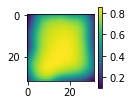

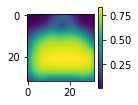

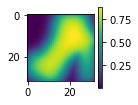

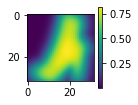

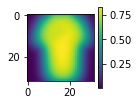

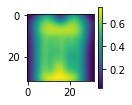

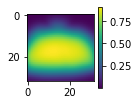

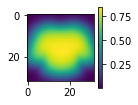

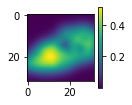

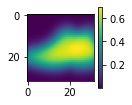

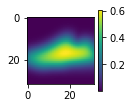

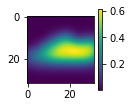

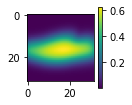

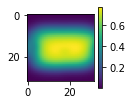

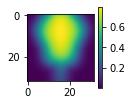

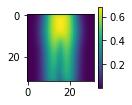

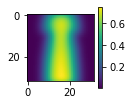

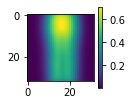

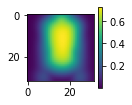

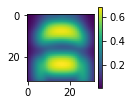

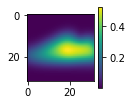

In [15]:
# printing all sampled barycenters
for i in range(sampled_barycenters.shape[0]):    
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(torch.tensor(sampled_barycenters[i]).view(32,32))
    plt.colorbar()
    plt.show()

In [16]:
#Computing wasserstein distance matrix for barycenters to calculate Persistent homology

In [ ]:
wass_dist_matrix = np.zeros((sampled_barycenters.shape[0], sampled_barycenters.shape[0]))
Mmm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]

#Mmm = torch.tensor(Mmm).type(torch.FloatTensor)
#Mmm = torch.tensor(Mmm).type(torch.FloatTensor)
for i in range(sampled_barycenters.shape[0]):
    for j in range(sampled_barycenters.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            #sampled_barycenters = sampled_barycenters.reshape(sampled_barycenters.shape[0], 1, sampled_barycenters.shape[1], sampled_barycenters.shape[2])
            gs = ((torch.tensor(sampled_barycenters[i]) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(sampled_barycenters[i])))
            h = ((torch.tensor(sampled_barycenters[j]) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(sampled_barycenters[j])))
            gs = gs.cpu().detach().numpy()
            h = h.cpu().detach().numpy()
            wassDistance = ot.sinkhorn2(h, gs, Mmm, 1)

            wass_dist_matrix[j, i] = wassDistance


In [ ]:
wass_dist_matrix.shape

In [ ]:
wass_dist_matrix.shape #.cpu().detach().numpy()

In [ ]:
diagrams = ripser.ripser(wass_dist_matrix, distance_matrix=True, maxdim=4)['dgms']


In [ ]:
diagrams

In [ ]:
plot_diagrams(diagrams, show=True)

In [ ]:
# Persistent homology calculation using l2 distance between barycenters

In [ ]:
dist_mat_FMNIST = _compute_distance_matrix(sampled_barycenters, p=2)

In [ ]:
_, PH_diagram_barycenters = get_persistence_diagram(sampled_barycenters, 4)